## English Description to Python Code Generation

In this project I have used Neural Transformer to convert English Description input to Python Code Generation. Neural transformer is based on famous paper “Attention is All You Need” https://arxiv.org/pdf/1706.03762.pdf.

Neural Transformer is based on Multi-head self attention. More details can be found in the medium article:

https://medium.com/@monimoyd/step-by-step-machine-translation-using-transformer-and-multi-head-attention-96435675be75


The Neural Transformer has Encoder and Decoder. Encoder is used for encoding input English sentences while Decoder is used for generating Python Code


![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

## Mount the Drive

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Copy all the datasets and APIs from Google Drive

In [2]:
!cp -rf '/content/drive/My Drive/english_to_python/datasets' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/pretrained_embeddings' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/vocabs' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/models' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/data_loaders' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/data_transformations' '/content'
!cp -rf '/content/drive/My Drive/english_to_python/utils' '/content'

! ls '/content'

data_loaders  data_transformations  models		   sample_data	vocabs
datasets      drive		    pretrained_embeddings  utils


## Import all the libraries needed, Downalod Spcay and install Google translator

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import nltk

import random
import math
import time

In [4]:
SEED = 6435

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
spacy_en = spacy.load('en')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
!pip install google_trans_new

In [8]:
from data_loaders.english_python_custom_dataset_loader import get_english_python_custom_dataset
from data_loaders.conala_dataset_loader import get_conala_dataset
from utils.clean_text_utils import clean_text
from data_loaders.english_python_tokenizers import tokenize_en, tokenize_python, tokenize_python_type
from models.english_to_python_transformer import Encoder, Decoder, Seq2Seq
from models.glove import GloveModel
from data_transformations.english_python_transformations import back_translate, random_deletion, random_swap, synonym_word, synonym_sentence
from utils.train_test_utils import train, evaluate
from utils.plot_metrics_utils import plot_loss, plot_ppl
from utils.translate_attention_utils import translate_sentence, display_attention, calculate_bleu, translate_code, exec_code


## Load the customer Python Dataset

In [9]:
english_text_python_program_pair_list = get_english_python_custom_dataset('/content/datasets/dataset_python_cleaned_final.txt')


## Load the Full Conala Dataset

In [10]:
conala_dataset = get_conala_dataset('/content/datasets/conala-combined.json')
english_text_python_program_pair_list.extend(conala_dataset)

## Create pandas frame from the combined custom python dataset and conala dataset

In [11]:
english_text_list,python_program_list  = zip(*english_text_python_program_pair_list)

In [12]:
import pandas as pd

df = pd.DataFrame({'English': english_text_list, 'Python':python_program_list })

## Apply clean on the datasets

In [13]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas() 

df['English'] = df['English'].progress_apply(lambda txt: clean_text(txt))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
df['Python'] = df['Python'].progress_apply(lambda txt: txt.lstrip())

In [15]:
df.head(10)

,English,Python
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,write a python function to merge two given lis...,"def merge_lists(l1, l2):\n return l1 + l2\n"
5,write a program to check whether a number is p...,"num = 337\nif num > 1:\n for i in range(2, n..."
6,write a python function that prints the factor...,"def print_factors(x):\n print(f""The factors ..."
7,write a program to find the factorial of a number,num = 13\nfactorial = 1\nif num < 0:\n print...
8,write a python function to print whether a num...,def check_pnz(num):\n if num > 0:\n p...
9,write a program to print the multiplication ta...,"num = 9\nfor i in range(1, 11):\n print(f""{n..."


In [16]:
import random
import torch, torchtext
from torchtext import data
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field, BucketIterator, Example, Dataset

import spacy
import numpy as np

import random
import math
import time

## Create Torch fields for Source Token, Python Token and Python Token Type

In [17]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_python, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            batch_first = True)

TRG_TYPE = Field(tokenize = tokenize_python_type, 
            init_token='<sos>', 
            eos_token='<eos>', 
            batch_first = True
            )

In [18]:
fields = [('English', SRC),('Python',TRG),('PythonType',TRG_TYPE)]

## Split the datasets into Train, Test and Validation 

In [19]:
from sklearn.model_selection import train_test_split

train_df1, test_data = train_test_split(df, test_size=0.05)

In [20]:
train_df, valid_data = train_test_split(train_df1, test_size=0.05)

In [21]:
train_augment_df = pd.DataFrame(columns=['English', 'Python'])
for index, row in train_df.iterrows():  
  train_augment_df = train_augment_df.append({'English':random_deletion(row['English']), 'Python': row['Python'] }, ignore_index=True)
  train_augment_df = train_augment_df.append({'English':random_swap(row['English']), 'Python':  row['Python']}, ignore_index=True ) 
  train_augment_df = train_augment_df.append({'English':synonym_sentence(row['English']), 'Python':  row['Python']}, ignore_index=True ) 
  if random.random() <= 0.05: 
    train_augment_df = train_augment_df.append({'English':back_translate(row['English']), 'Python':  row['Python'] }, ignore_index=True)

In [22]:
train_data = pd.concat([train_df, train_augment_df],axis=0)

In [23]:
# train_data, valid_data = train_test_split(train_df_concat, test_size=0.05)

In [24]:
train_data = train_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing
valid_data = valid_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing
test_data = test_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing

In [25]:
train_data

,English,Python
0,write a python program to check whether a pers...,"age=23\nif age>=18:\n status=""Eligible""..."
1,write a python program to print all pair combi...,"test_tuple1 = (4, 5) \ntest_tuple2 = (7, 8) ..."
2,write a python program to implement gnome sort...,def gnome_sort(alist):\n for pos in range(1...
3,how to get the context of a search in beautifu...,k = soup.find(text=re.compile('My keywords'))....
4,selecting with complex criteria from pandasdat...,df['A'][(df['B'] > 50) & (df['C'] == 900)]
...,...,...
38291,a write python a of takes in sequences list of...,def zip_(list_of_seq):\n return list(zip(*l...
38292,write a python mapping that guide in a leaning...,def zip_(list_of_seq):\n return list(zip(*l...
38293,sort list of strings list by suffix,"sorted(the_list, key=lambda k: int(k.split('_'..."
38294,of in sort strings list list integer by thelis...,"sorted(the_list, key=lambda k: int(k.split('_'..."


In [26]:
print("Train Dimension: ", train_data.shape)
print("Validation Dimension: ", valid_data.shape)
print("Test Dimension: ", test_data.shape)

Train Dimension:  (38296, 2)
Validation Dimension:  (498, 2)
Test Dimension:  (525, 2)


## Define maximum sequnece length for input and output

In [27]:
MAX_OUTPUT_SEQ_LENGTH = 250
MAX_INPUT_SEQ_LENGTH = 100

# Create datasets for Train, Validation, Test

In [28]:
example_trng = [Example.fromlist([train_data.English[i],train_data.Python[i], train_data.Python[i]], fields) for i in range(train_data.shape[0]) if len(train_data.Python[i]) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(train_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(train_data.English[i]) > 2 ] 
example_val = [Example.fromlist([valid_data.English[i],valid_data.Python[i], valid_data.Python[i]], fields) for i in range(valid_data.shape[0]) if len(valid_data.Python[i]) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(valid_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(valid_data.English[i]) > 2 ] 
example_test = [Example.fromlist([test_data.English[i],test_data.Python[i], test_data.Python[i]], fields) for i in range(test_data.shape[0]) if len(test_data.Python[i]) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(test_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(test_data.English[i] )> 2 ] 

In [29]:
train_dataset = Dataset(example_trng, fields)
valid_dataset = Dataset(example_val, fields)
test_dataset = Dataset(example_test, fields)

In [30]:
vars(train_dataset.examples[5])

{'English': ['get',
  'all',
  'digits',
  'in',
  'a',
  'string',
  's',
  'after',
  'a',
  'character'],
 'Python': ['re',
  '.',
  'findall',
  '(',
  "'\\\\d+(?=[^[]+$)'",
  ',',
  's',
  ')',
  'NEWLINE'],
 'PythonType': ['IDENTIFIER',
  'OP',
  'IDENTIFIER',
  'OP',
  'STRING',
  'OP',
  'IDENTIFIER',
  'OP',
  'NEWLINE']}

## Create Vocabulary from Training Dataset and store in json to be used during deployment

In [31]:
SRC.build_vocab(train_dataset, min_freq = 1)
TRG.build_vocab(train_dataset, min_freq = 1)
TRG_TYPE.build_vocab(train_dataset, min_freq = 1)

In [32]:
import pickle
import json
with open("/content/drive/My Drive/english_to_python/vocabs/SRC_stoi_final.json", "w") as fj1:
    fj1.write(json.dumps(dict(SRC.vocab.stoi)))

with open("/content/drive/My Drive/english_to_python/vocabs/TRG_stoi_final.json", "w") as fj2:
    fj2.write(json.dumps(dict(TRG.vocab.stoi)))

with open("/content/drive/My Drive/english_to_python/vocabs/TRG_TYPE_stoi_final.json", "w") as fj3:
    fj3.write(json.dumps(dict(TRG_TYPE.vocab.stoi)))

In [33]:
src_itos = { i:s for (i,s ) in enumerate(SRC.vocab.itos)}
trg_itos = { i:s for (i,s ) in enumerate(TRG.vocab.itos)}
trg_type_itos = { i:s for (i,s ) in enumerate(TRG_TYPE.vocab.itos)}

In [34]:
with open("/content/drive/My Drive/english_to_python/vocabs/SRC_itos_final.json", "w") as fj_itos_1:
    fj_itos_1.write(json.dumps(src_itos))

with open("/content/drive/My Drive/english_to_python/vocabs/TRG_itos_final.json", "w") as fj_itos_2:
    fj_itos_2.write(json.dumps(trg_itos))

with open("/content/drive/My Drive/english_to_python/vocabs/TRG_TYPE_itos_final.json", "w") as fj_itos_3:
    fj_itos_3.write(json.dumps(trg_type_itos))

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Create Iterators for train, validation, test

In [36]:
BATCH_SIZE=128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x:len(x.English),
    sort_within_batch = False, 
    device = device)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

## Create Encoder, Decoder, Seq2Seq model

In [37]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
OUTPUT_TYPE_DIM = len(TRG_TYPE.vocab)
HID_DIM = 300
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 6
DEC_HEADS = 6
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM,
              OUTPUT_TYPE_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=MAX_OUTPUT_SEQ_LENGTH
              )

## Initialize all the weights

In [38]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
SRC_UNK_IDX = SRC.vocab.stoi[SRC.unk_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_TYPE_PAD_IDX = TRG_TYPE.vocab.stoi[TRG_TYPE.pad_token]
TRG_TYPE_UNK_IDX = TRG_TYPE.vocab.stoi[TRG_TYPE.unk_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,280,803 trainable parameters


In [40]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [41]:
model.apply(initialize_weights);

In [42]:
! ls -l /content/vocabs/

total 828
-rw------- 1 root root  90922 Mar 21 03:54 combined_dataset_vocab_300_english.pkl
-rw------- 1 root root 219074 Mar 21 03:54 combined_dataset_vocab_300_python.pkl
-rw------- 1 root root 116896 Mar 21 03:54 SRC_itos.json
-rw------- 1 root root 104806 Mar 21 03:54 SRC_stoi.json
-rw------- 1 root root 153139 Mar 21 03:54 TRG_itos.json
-rw------- 1 root root 140255 Mar 21 03:54 TRG_stoi.json
-rw------- 1 root root    200 Mar 21 03:54 TRG_TYPE_itos.json
-rw------- 1 root root    174 Mar 21 03:54 TRG_TYPE_stoi.json


## Load the pretrained Glove embeddings for English Texts and Python codes

In [43]:
import pickle
source_dict_english = None
with open('/content/vocabs/combined_dataset_vocab_300_english.pkl',  'rb' ) as f:
    source_dict_english = pickle.load(f)

In [44]:
import pickle
target_dict_python = None
with open('/content/vocabs/combined_dataset_vocab_300_python.pkl',  'rb' ) as f:
    target_dict_python = pickle.load(f)

In [45]:
glove_model_english = GloveModel(len(source_dict_english ), ENC_EMB_DIM)
#map_location=torch.device('cpu')
#glove_model.load_state_dict(torch.load('glove_combined_300.pt', map_location))
glove_model_english.load_state_dict(torch.load('/content/pretrained_embeddings/glove_combined_300_english.pt'))

<All keys matched successfully>

In [46]:
source_glove_state_dict = glove_model_english.state_dict()
for token in SRC.vocab.stoi:
    token_id_glove_embedding = source_dict_english.get(token)
    if token_id_glove_embedding is not None:
        enc.tok_embedding.weight.data[SRC.vocab.stoi[token]] = source_glove_state_dict['wi.weight'][token_id_glove_embedding] + source_glove_state_dict['wj.weight'][token_id_glove_embedding]
    else:
        print("token: ", token, " is not present in source glove embedding")

token:  <unk>  is not present in source glove embedding
token:  <pad>  is not present in source glove embedding
token:  -  is not present in source glove embedding
token:  adenine  is not present in source glove embedding
token:  ampere  is not present in source glove embedding
token:  angstrom  is not present in source glove embedding
token:  axerophthol  is not present in source glove embedding
token:  programme  is not present in source glove embedding
token:  type_a  is not present in source glove embedding
token:  lean  is not present in source glove embedding
token:  vitamin_a  is not present in source glove embedding
token:  amp  is not present in source glove embedding
token:  group_a  is not present in source glove embedding
token:  antiophthalmic_factor  is not present in source glove embedding
token:  lexicon  is not present in source glove embedding
token:  angstrom_unit  is not present in source glove embedding
token:  deoxyadenosine_monophosphate  is not present in source

In [47]:
enc.tok_embedding.weight.data[SRC_PAD_IDX] = torch.zeros(ENC_EMB_DIM)
enc.tok_embedding.weight.data[SRC_UNK_IDX] = torch.zeros(ENC_EMB_DIM)
#enc.tok_embedding.weight.requires_grad=False

In [48]:
glove_model_python = GloveModel(len(target_dict_python), DEC_EMB_DIM)
#map_location=torch.device('cpu')
#glove_model.load_state_dict(torch.load('glove_combined_300.pt', map_location))
glove_model_python.load_state_dict(torch.load('/content/pretrained_embeddings/glove_combined_300_python.pt'))

<All keys matched successfully>

In [49]:
target_glove_state_dict = glove_model_python.state_dict()
for token in TRG.vocab.stoi:
    token_id_glove_embedding = target_dict_python.get(token)
    if token_id_glove_embedding is not None:
        dec.tok_embedding.weight.data[TRG.vocab.stoi[token]] = target_glove_state_dict['wi.weight'][token_id_glove_embedding] + target_glove_state_dict['wj.weight'][token_id_glove_embedding]
    else:
        print("token: ", token, " is not present in target glove embedding")

token:  <unk>  is not present in target glove embedding
token:  <pad>  is not present in target glove embedding


In [50]:
dec.tok_embedding.weight.data[TRG_PAD_IDX] = torch.zeros(DEC_EMB_DIM)
dec.tok_embedding.weight.data[TRG_UNK_IDX] = torch.zeros(DEC_EMB_DIM)
dec.type_embedding.weight.data[TRG_TYPE_PAD_IDX] = torch.zeros(DEC_EMB_DIM)
dec.type_embedding.weight.data[TRG_TYPE_UNK_IDX] = torch.zeros(DEC_EMB_DIM)
#dec.tok_embedding.weight.requires_grad=False

## Define Learning Rate and Adam Optimizer

In [51]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

## Create Criteria based on CrossEntropy Loss

In [52]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [53]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [54]:
MODEL_PATH= '/content/drive/My Drive/english_to_python/model_weights/english_python_final_latest.pt'

## Perform Training

In [55]:
N_EPOCHS = 100
CLIP = 1

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

best_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
train_ppl_list = []
valid_ppl_list = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_PATH)

    train_loss_list.append(train_loss)
    train_ppl_list.append(math.exp(train_loss))
    valid_loss_list.append(valid_loss)
    valid_ppl_list.append(math.exp(valid_loss))
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    scheduler.step(valid_loss)

Epoch: 01 | Time: 0m 51s
	Train Loss: 7.801 | Train PPL: 2443.669
	 Val. Loss: 5.193 |  Val. PPL: 180.078
Epoch: 02 | Time: 0m 50s
	Train Loss: 4.536 | Train PPL:  93.283
	 Val. Loss: 3.950 |  Val. PPL:  51.932
Epoch: 03 | Time: 0m 50s
	Train Loss: 3.643 | Train PPL:  38.203
	 Val. Loss: 3.372 |  Val. PPL:  29.135
Epoch: 04 | Time: 0m 51s
	Train Loss: 3.077 | Train PPL:  21.683
	 Val. Loss: 2.895 |  Val. PPL:  18.089
Epoch: 05 | Time: 0m 50s
	Train Loss: 2.646 | Train PPL:  14.095
	 Val. Loss: 2.625 |  Val. PPL:  13.810
Epoch: 06 | Time: 0m 51s
	Train Loss: 2.314 | Train PPL:  10.112
	 Val. Loss: 2.343 |  Val. PPL:  10.416
Epoch: 07 | Time: 0m 51s
	Train Loss: 2.033 | Train PPL:   7.635
	 Val. Loss: 2.180 |  Val. PPL:   8.848
Epoch: 08 | Time: 0m 51s
	Train Loss: 1.800 | Train PPL:   6.051
	 Val. Loss: 1.997 |  Val. PPL:   7.363
Epoch: 09 | Time: 0m 51s
	Train Loss: 1.611 | Train PPL:   5.009
	 Val. Loss: 1.872 |  Val. PPL:   6.504
Epoch: 10 | Time: 0m 51s
	Train Loss: 1.457 | Train PP

## Load the best model and find validation, test loss and PPL values

In [56]:
model.load_state_dict(torch.load(MODEL_PATH))

valid_loss = evaluate(model, valid_iterator, criterion)

print(f'| Validation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):7.3f} |')

| Validation Loss: 1.444 | Validation PPL:   4.236 |


In [57]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.619 | Test PPL:   5.046 |


## Plot Loss and PPL for Train and validation

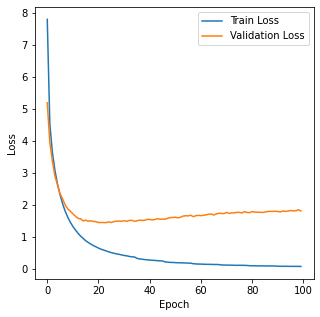

In [58]:
plot_loss(train_loss_list, valid_loss_list)

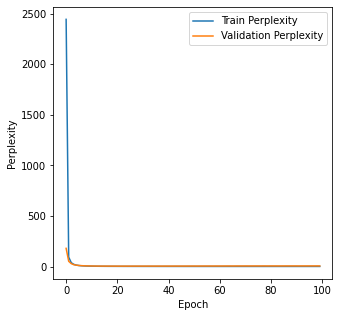

In [59]:
plot_ppl(train_ppl_list, valid_ppl_list)

## Display some of the results of python code generation and plot the attention

In [60]:
example_idx = 8

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'python', 'program', 'to', 'print', 'the', 'number', 'of', 'letters', 'and', 'digits', 'in', 'sentence']
trg = ['sentence', '=', "'The Quick 123 Fox'", 'NEWLINE', 'digits', '=', '0', 'NEWLINE', 'letters', '=', '0', 'NEWLINE', 'for', 'c', 'in', 'sentence', ':', 'NEWLINE', 'INDENT', 'if', 'c', '.', 'isdigit', '(', ')', ':', 'NEWLINE', 'INDENT', 'digits', '+=', '1', 'NEWLINE', 'DEDENT', 'elif', 'c', '.', 'isalpha', '(', ')', ':', 'NEWLINE', 'INDENT', 'letters', '+=', '1', 'NEWLINE', 'DEDENT', 'else', ':', 'NEWLINE', 'INDENT', 'pass', 'NEWLINE', 'DEDENT', 'DEDENT', 'print', '(', "f'Digits: {digits}, Letters: {letters}'", ')', 'NEWLINE']


In [61]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
write a python program to print the number of letters and digits in sentence

Predicted Python Code:
import pyforest
word = "Hello World"
print(f"Length of string: {len(word)}")


Actual Python Code:
import pyforest
sentence = 'The Quick 123 Fox'
digits = 0
letters = 0
for c in sentence :
    if c.isdigit() :
        digits += 1
    elif c.isalpha() :
        letters += 1
    else :
        pass
print(f'Digits: {digits}, Letters: {letters}')



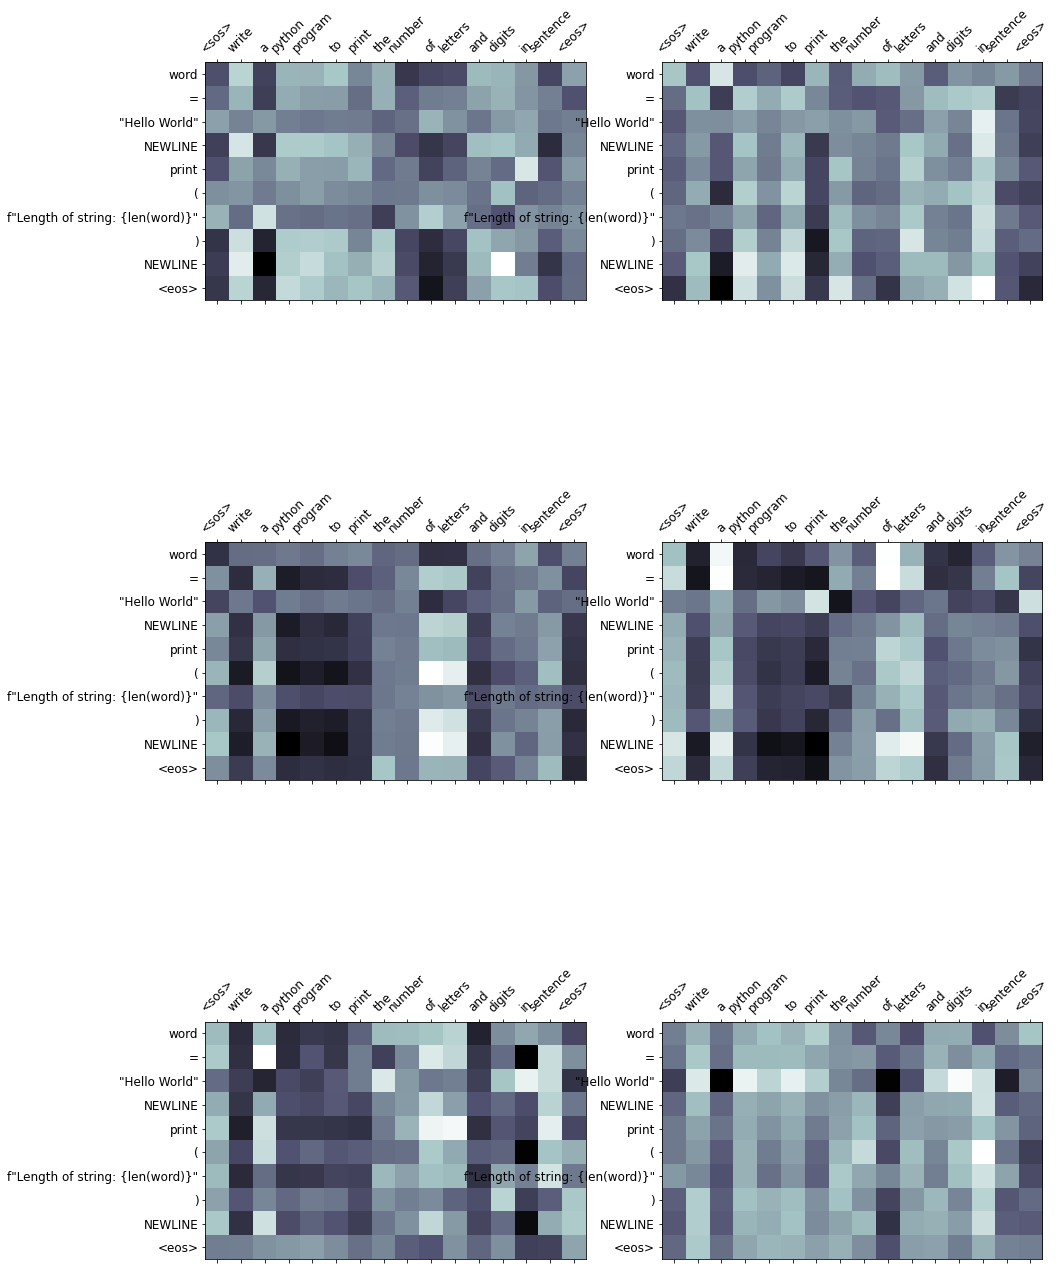

In [62]:
display_attention(src, translation, attention)


In [63]:
example_idx = 16

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['none']
trg = ['datetime', '.', 'datetime', '.', 'strptime', '(', "'2007-03-04T21:08:12'", ',', "'%Y-%m-%dT%H:%M:%S'", ')', 'NEWLINE']


In [64]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
none

Predicted Python Code:
import pyforest
df.groupby([ 'col1' , 'col2' ]).nunique().reset_index()


Actual Python Code:
import pyforest
import datetime
datetime.datetime.strptime('2007-03-04T21:08:12' , '%Y-%m-%dT%H:%M:%S')



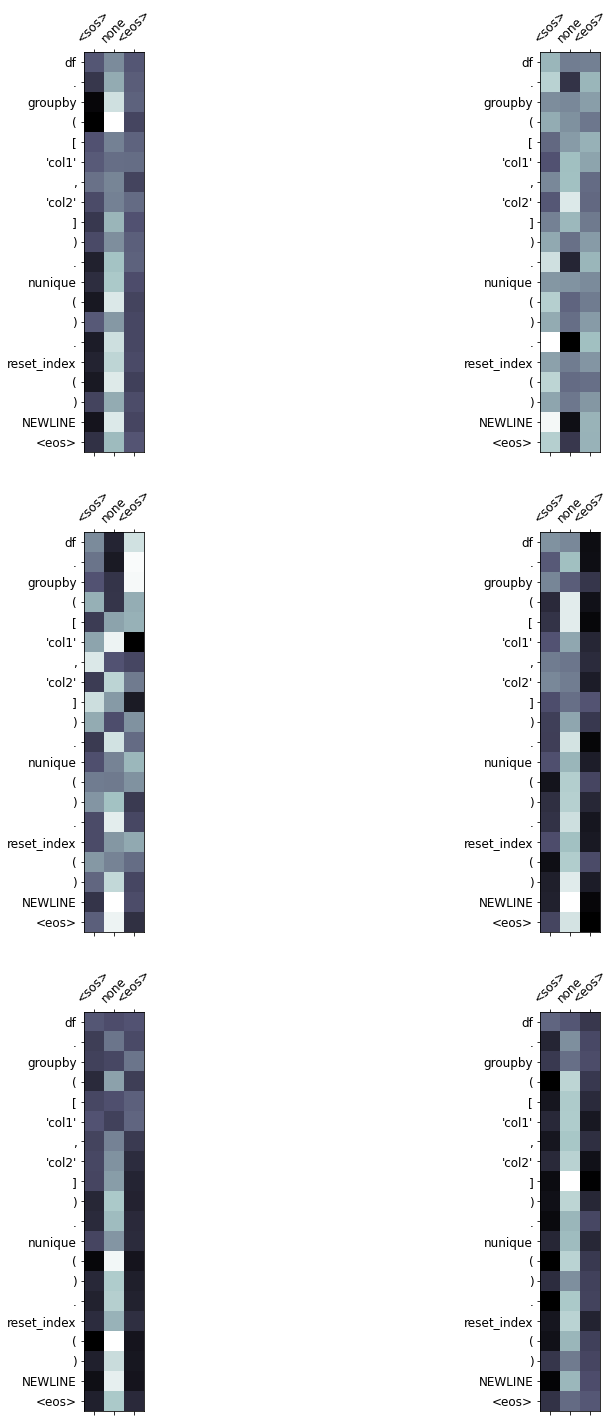

In [65]:
display_attention(src, translation, attention)

In [66]:
example_idx = 25

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['sort', 'dictionary', 'u', 'in', 'ascending', 'order', 'based', 'on', 'second', 'elements', 'of', 'its', 'values']
trg = ['sorted', '(', 'list', '(', 'u', '.', 'items', '(', ')', ')', ',', 'key', '=', 'lambda', 'v', ':', 'v', '[', '1', ']', ')', 'NEWLINE']


In [67]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
sort dictionary u in ascending order based on second elements of its values

Predicted Python Code:
import pyforest
sorted(list(d.items()) , key = lambda name_num :(name_num [ 0 ].rsplit(None , 1) [ 0 ] , name_num [ 0 ]))


Actual Python Code:
import pyforest
sorted(list(u.items()) , key = lambda v : v [ 1 ])



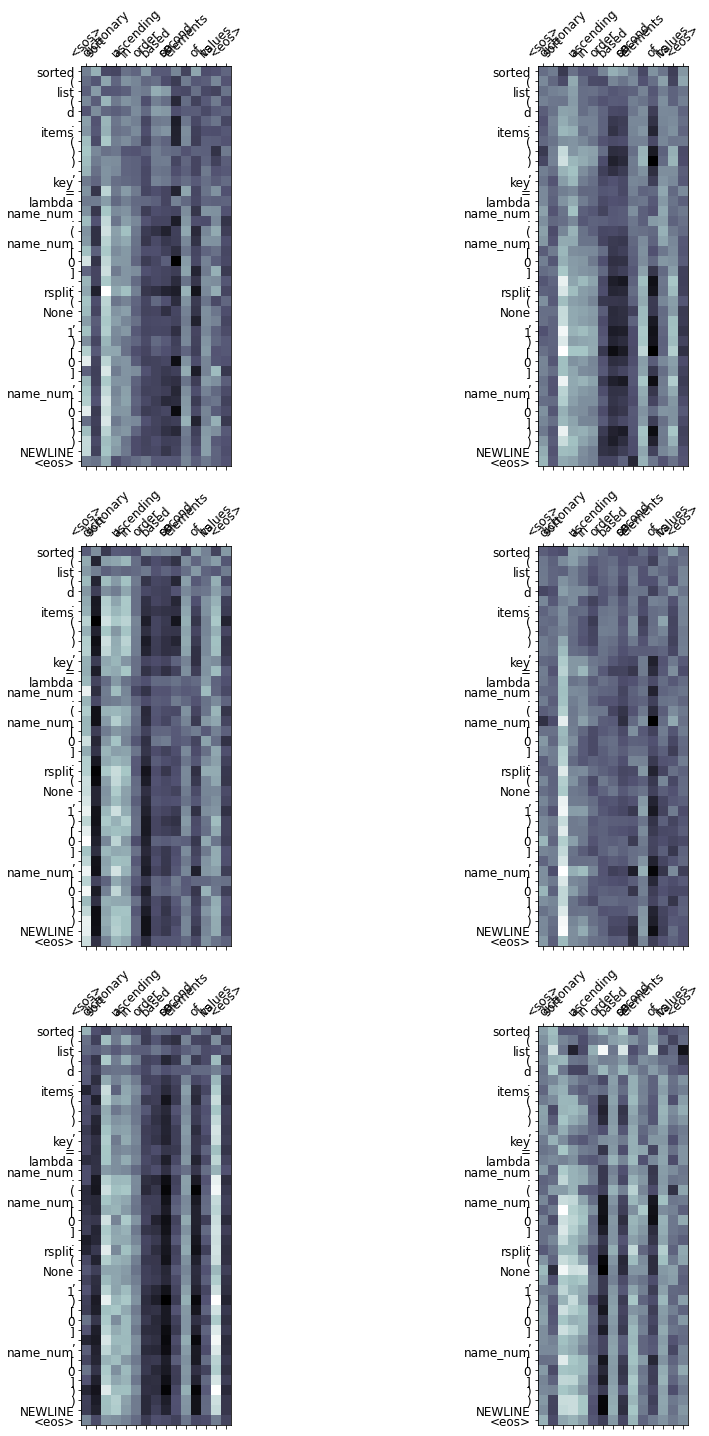

In [68]:
display_attention(src, translation, attention)

In [69]:
example_idx = 6

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['open', 'images']
trg = ['img', '=', 'Image', '.', 'open', '(', "'picture.jpg'", ')', 'NEWLINE', 'img', '.', 'show', '(', ')', 'NEWLINE']


In [70]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
open images

Predicted Python Code:
import pyforest
img = Image.open('picture.jpg')
Img.show


Actual Python Code:
import pyforest
img = Image.open('picture.jpg')
img.show()



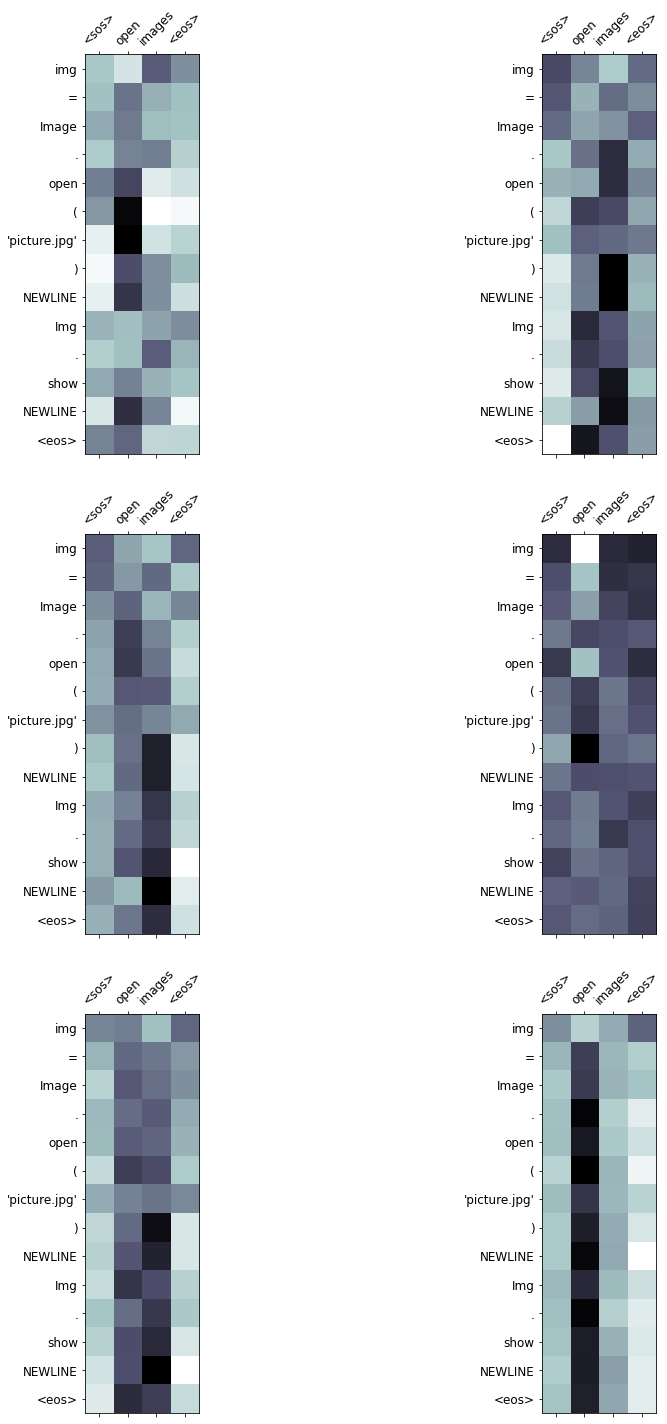

In [71]:
display_attention(src, translation, attention)


In [72]:
example_idx = 36

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'function', 'that', 'returns', 'sine', 'value', 'of', 'the', 'input']
trg = ['def', 'sin', '(', 'x', ':', 'float', ')', '->', 'float', ':', 'NEWLINE', 'INDENT', 'return', 'math', '.', 'sin', '(', 'x', ')', 'NEWLINE', 'DEDENT']


In [73]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
write a function that returns sine value of the input

Predicted Python Code:
import pyforest
def derivative_cos(x : float) -> float :
    return -(math.sin(x))


Actual Python Code:
import pyforest
def sin(x : float) -> float :
    return math.sin(x)



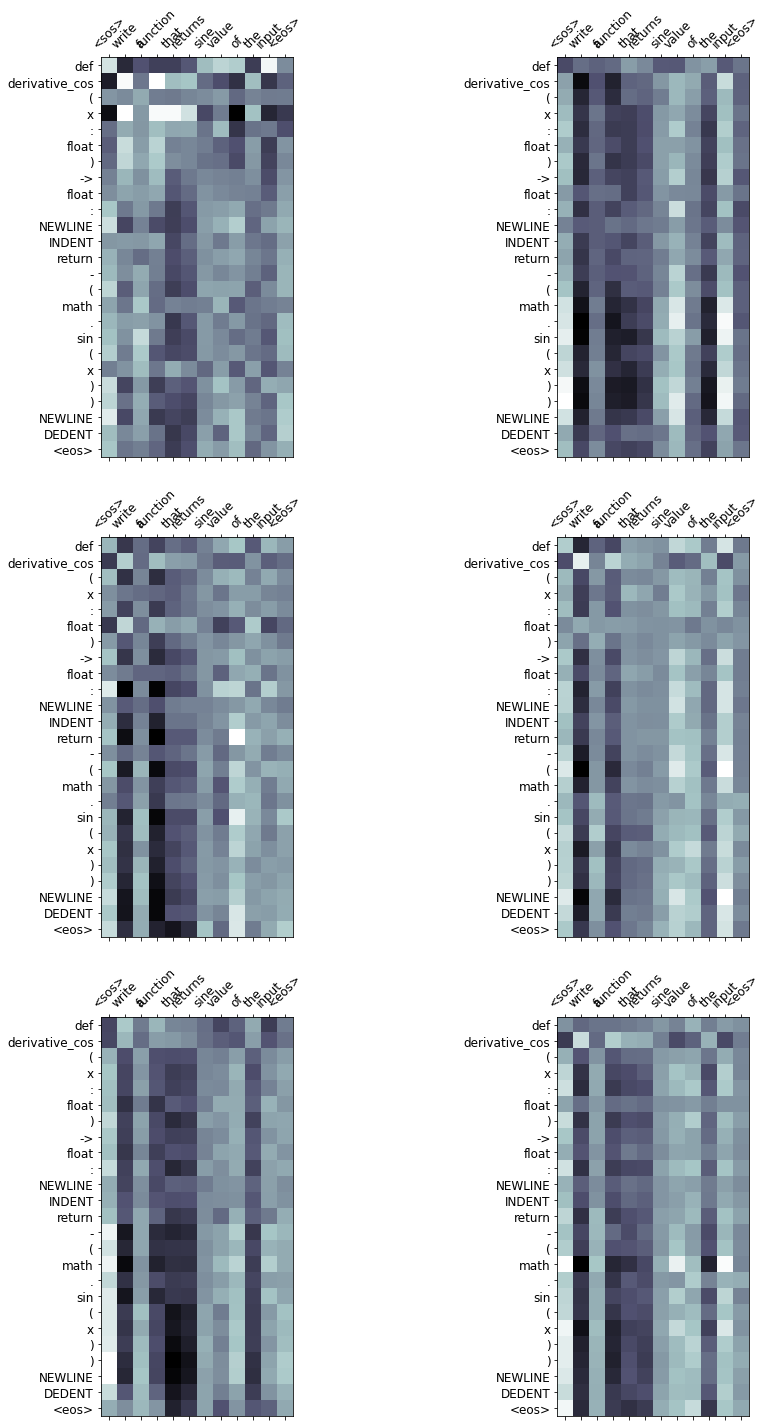

In [74]:
display_attention(src, translation, attention)

In [75]:
example_idx = 59

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['arrange', 'string', 'characters', 'such', 'that', 'lowercase', 'letters', 'should', 'come', 'first']
trg = ['str1', '=', '"PyNaTive"', 'NEWLINE', 'lower', '=', '[', ']', 'NEWLINE', 'upper', '=', '[', ']', 'NEWLINE', 'for', 'char', 'in', 'str1', ':', 'NEWLINE', 'INDENT', 'if', 'char', '.', 'islower', '(', ')', ':', 'NEWLINE', 'INDENT', 'lower', '.', 'append', '(', 'char', ')', 'NEWLINE', 'DEDENT', 'else', ':', 'NEWLINE', 'INDENT', 'upper', '.', 'append', '(', 'char', ')', 'NEWLINE', 'DEDENT', 'DEDENT', 'sorted_string', '=', "''", '.', 'join', '(', 'lower', '+', 'upper', ')', 'NEWLINE', 'print', '(', 'sorted_string', ')', 'NEWLINE']


In [76]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
arrange string characters such that lowercase letters should come first

Predicted Python Code:
import pyforest
str1 = "PyNaTive"
lower = [ ]
upper = [ ]
for char in str1 :
    if char.islower() :
        lower.append(char)
    else :
        upper.append(char)
sorted_string = ''.join(lower + upper)
print(sorted_string)


Actual Python Code:
import pyforest
str1 = "PyNaTive"
lower = [ ]
upper = [ ]
for char in str1 :
    if char.islower() :
        lower.append(char)
    else :
        upper.append(char)
sorted_string = ''.join(lower + upper)
print(sorted_string)



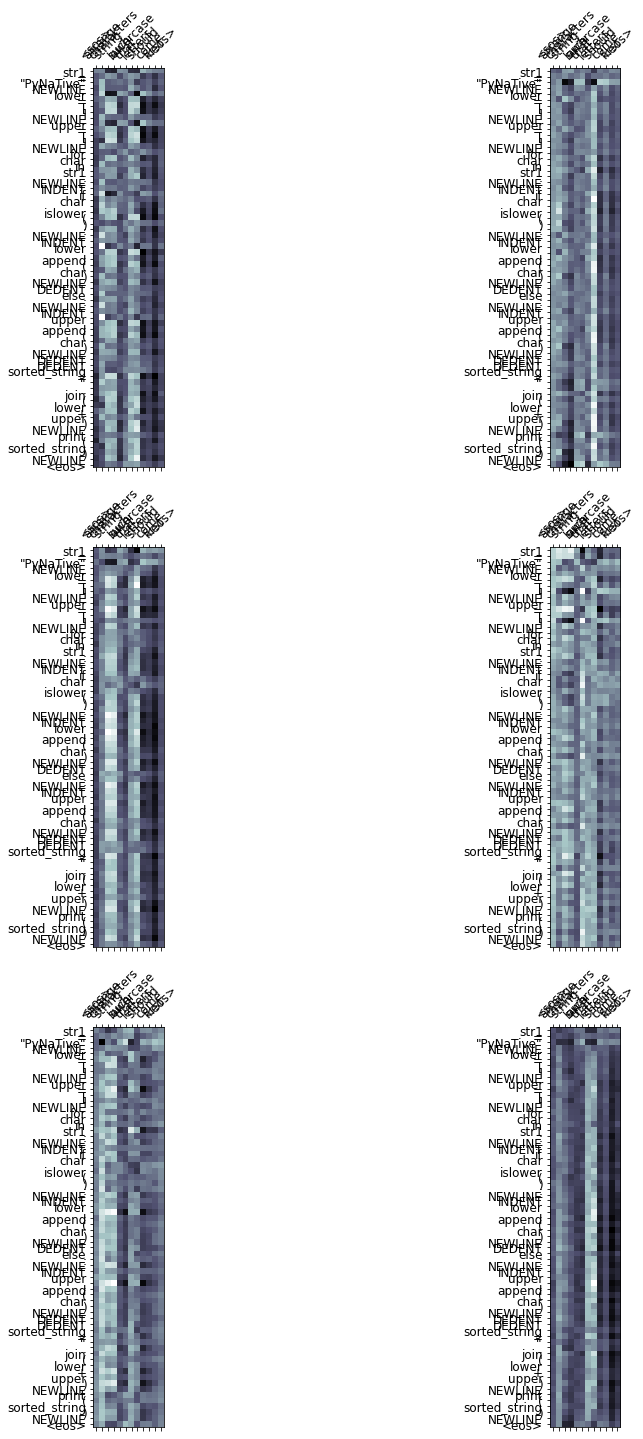

In [77]:
display_attention(src, translation, attention)

In [78]:
example_idx = 11

src = vars(test_dataset.examples[example_idx])['English']
trg = vars(test_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'python3', 'program', 'for', 'illustration', 'of', 'values', 'method', 'of', 'dictionary']
trg = ['dictionary', '=', '{', '"raj"', ':', '2', ',', '"striver"', ':', '3', ',', '"vikram"', ':', '4', '}', 'NEWLINE', 'print', '(', 'dictionary', '.', 'values', '(', ')', ')', 'NEWLINE']


In [79]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
write python3 program for illustration of values method of dictionary

Predicted Python Code:
import pyforest
test_dict = { 'gfg' : True , 'is' : False , 'best' : True }
print("The original dictionary is : " + str(test_dict))
res = True
for key , value in test_dict.items() :
    if key in res.items() :
        res = False
        break
print(f"Dictionary is {res}")


Actual Python Code:
import pyforest
dictionary = { "raj" : 2 , "striver" : 3 , "vikram" : 4 }
print(dictionary.values())



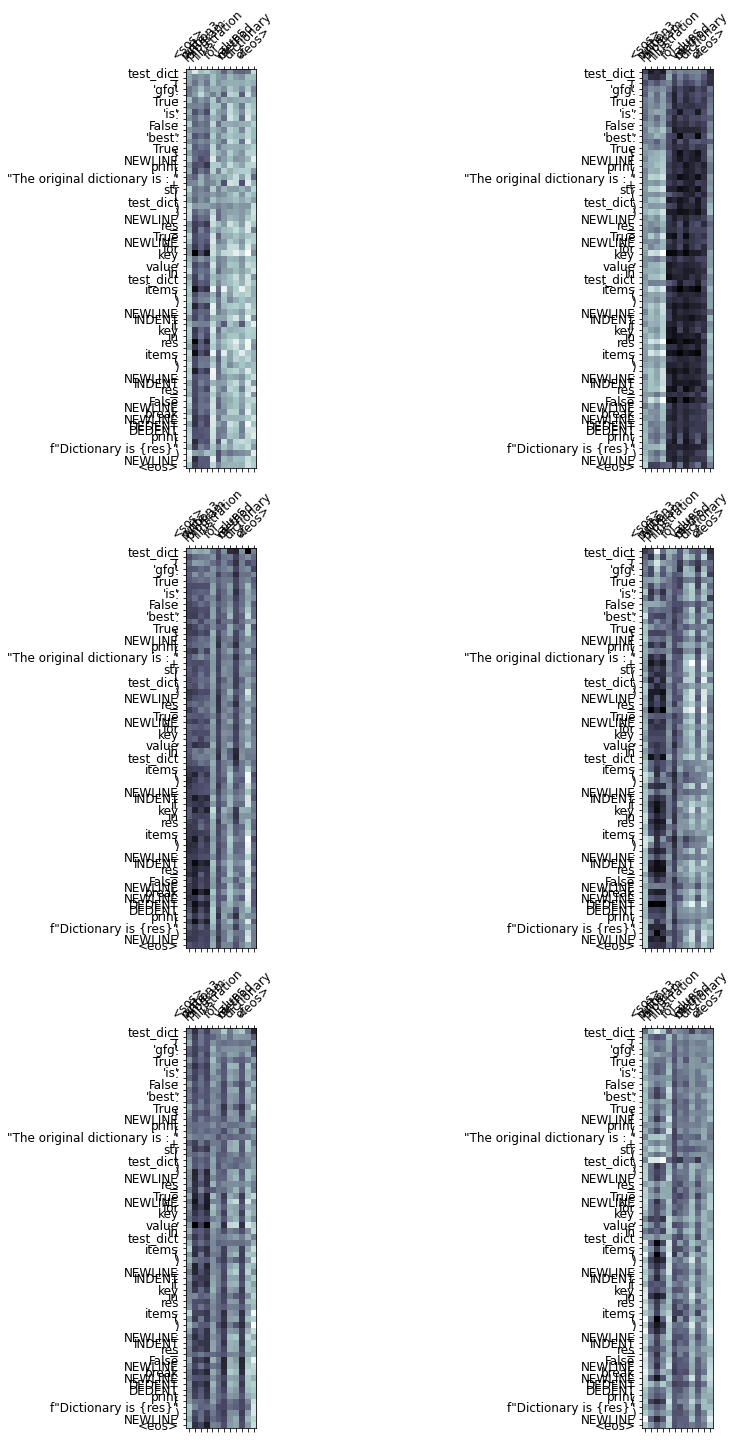

In [80]:
display_attention(src, translation, attention)

In [81]:
example_idx = 155

src = vars(test_dataset.examples[example_idx])['English']
trg = vars(test_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['zip', 'lists', 'in', 'python']
trg = ['zip', '(', '[', '1', ',', '2', ']', ',', '[', '3', ',', '4', ']', ')', 'NEWLINE']


In [82]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)
predicted_python_code = translate_code(translation)
english_descr = " ".join(src)
actual_code = translate_code(trg)
print(f'English Description: \n{english_descr}')
print(f'\nPredicted Python Code:\n{predicted_python_code}')
print(f'\nActual Python Code:\n{actual_code}')

English Description: 
zip lists in python

Predicted Python Code:
import pyforest
zip(* [ [ 1 , 2 ] , [ 3 , 4 ] , [ 5 , 6 ] ])


Actual Python Code:
import pyforest
zip([ 1 , 2 ] , [ 3 , 4 ])



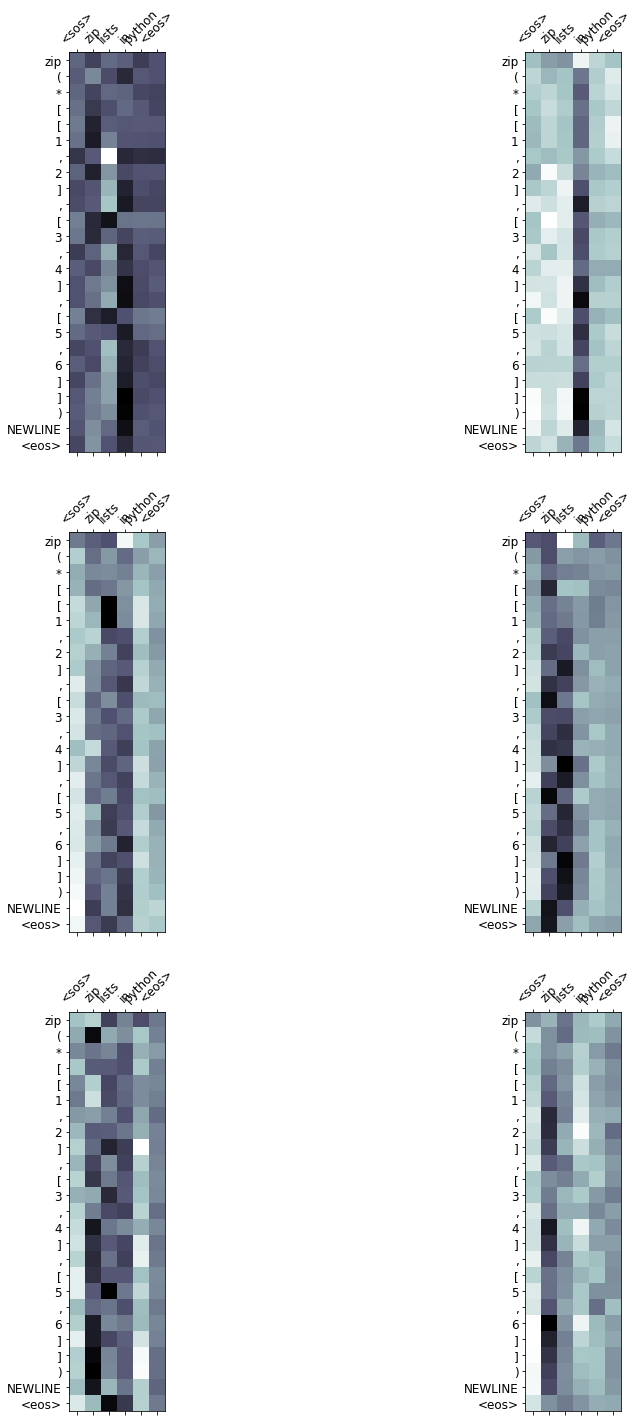

In [83]:
display_attention(src, translation, attention)

## Calculate the BLEU Score for test and validation

In [84]:
valid_bleu_score = calculate_bleu(valid_dataset, SRC, TRG, TRG_TYPE, model, device)

print(f'Validation BLEU score = {valid_bleu_score*100:.2f}')

Validation BLEU score = 39.16


In [86]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, TRG_TYPE, model, device)

print(f'Test BLEU score = {bleu_score*100:.2f}')

Test BLEU score = 41.61
